# 신문사 성향 별 대한민국 정치흐름 파악

<font color='CC3D3D'>
    
[라이브러리 불러오기](#라이브러리-불러오기)  
[데이터 수집](#데이터-수집)  
[전처리](#전처리)  
[단어 빈도](#단어-빈도)  
[감성 분석](#감성-분석)  
[주제 분석](#주제-분석)

#  <font color ='CC3D3D'>라이브러리 불러오기

In [1]:
import seaborn as sns
import matplotlib.pylab as plt
from matplotlib import font_manager, rc
%matplotlib inline

import platform
your_os = platform.system()
if your_os == 'Linux':
    rc('font', family='NanumGothic')
elif your_os == 'Windows':
    ttf = "c:/Windows/Fonts/malgun.ttf"
    font_name = font_manager.FontProperties(fname=ttf).get_name()
    rc('font', family=font_name)
elif your_os == 'Darwin':
    rc('font', family='AppleGothic')
rc('axes', unicode_minus=False)

In [3]:
from tqdm.notebook import tqdm
import pandas as pd
import numpy as np
import requests
import lxml.html
import re
import stanza
import joblib
import sklearn
from wordcloud import WordCloud
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from selenium.webdriver import Chrome
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.decomposition import TruncatedSVD
from sklearn.decomposition import NMF
from gensim.models.ldamodel import LdaModel
from gensim.models import CoherenceModel
from gensim.matutils import Sparse2Corpus
from gensim.corpora.dictionary import Dictionary
from factor_analyzer.rotator import Rotator
import pyLDAvis.gensim
import tensorflow as tf
import openpyxl
import warnings
warnings.filterwarnings('ignore', category=DeprecationWarning)

# <font color ='CC3D3D'>데이터 수집

### 보수(우파) 언론사
- 조선일보
- 중앙일보
- 동아일보
- 한국경제

### 1. 조선일보

In [12]:
browser = Chrome()
wb = openpyxl.Workbook()
sheet = wb.active
browser.get('https://www.chosun.com/opinion/editorial/')

In [13]:
for i in browser.find_elements_by_css_selector('div#main div.story-feed div.story-card a.text__link span'):
    sheet.append([f'{i.text}'])
wb.save('chosun.xlsx')

### 2. 중앙일보

In [14]:
browser = Chrome()
wb = openpyxl.Workbook()
sheet = wb.active
for page_num in range(1, 38):
    browser.get(f'https://news.joins.com/find/list?page={page_num}&IsDuplicate=False&key=EditorialColumn&Display=%EC%82%AC%EC%84%A4&Keyword=%EC%82%AC%EC%84%A4&SourceGroupType=all&ServiceCode=20%2C34&SourceCode=1%2C61')
    for i in browser.find_elements_by_css_selector('div#content div.list_basic li h2 a'):
        sheet.append([f'{i.text}'])
wb.save('JoongAng.xlsx')

### 3. 동아일보

In [15]:
browser = Chrome()
wb = openpyxl.Workbook()
sheet = wb.active
for page_num in range(1, 1202, 20):
    browser.get(f'https://www.donga.com/news/Series/70040100000001?p={page_num}&prod=news&ymd=&m=')
    for i in browser.find_elements_by_css_selector('div#content a span.tit'):
        sheet.append([f'{i.text}'])
wb.save('donga.xlsx')

### 4. 한국경제

In [16]:
browser = Chrome()
wb = openpyxl.Workbook()
sheet = wb.active
for page_num in range(1, 62):
    browser.get(f'https://www.hankyung.com/opinion/0001?page={page_num}')
    for i in browser.find_elements_by_css_selector('div#container li h3.tit a'):
        sheet.append([f'{i.text}'])
wb.save('hanguk.xlsx')

### 좌파(진보) 언론사
- 한겨례
- 프레시안
- 경향신문
- 머니투데이
- 이데일리

### 1. 한겨례

In [5]:
browser = Chrome()
wb = openpyxl.Workbook()
sheet = wb.active
for page_num in range(1, 82):
    browser.get(f'http://www.hani.co.kr/arti/opinion/editorial/list{page_num}.html')
    for i in browser.find_elements_by_css_selector('div#section-left-scroll-in div.section-list-area div h4 a'):
        sheet.append([f'{i.text}'])
wb.save('Hangye.xlsx')

### 2. 프레시안

In [6]:
browser = Chrome()
wb = openpyxl.Workbook()
sheet = wb.active
for page_num in range(1, 55):
    browser.get(f'https://m.pressian.com/m/pages/opinion-column?page={page_num}')
    for i in browser.find_elements_by_css_selector('#container div div.arl_026 ul li div.box p a'):
        sheet.append([f'{i.text}'])
wb.save('Presian.xlsx')

### 3. 경향신문

In [3]:
browser = Chrome()
wb = openpyxl.Workbook()
sheet = wb.active
browser.get('https://m.khan.co.kr/list.html?type=opinion')

In [4]:
i=0
while (i<=582):
    try :
        browser.find_element_by_css_selector('button.link_corp.btn_more').click()
        i+=1
    except:
        pass 

In [5]:
wb = openpyxl.Workbook()
sheet = wb.active
con = browser.find_elements_by_css_selector('ul#itemsBody.list_df li')

for i in range(len(con)):
    try: 
        if con[i].find_element_by_css_selector("#itemsBody li a div.cont_thumb em").text == '사설':
            title = con[i].find_element_by_css_selector("#itemsBody li a div.cont_thumb strong")
            sheet.append([f'{title.text}'])
    except:
        pass
    
wb.save('Kyunghyang.xlsx')

### 4. 머니투데이

In [4]:
browser = Chrome()
wb = openpyxl.Workbook()
sheet = wb.active
for page_num in range(1, 16):
    browser.get(f'https://news.mt.co.kr/column/opinion_inside.html?category=03&page={page_num}')
    for i in browser.find_elements_by_css_selector('#content ul.conlist_p1.mgt20 li div strong a'):
        sheet.append([f'{i.text}'])
wb.save('moneytoday.xlsx')

### 5. 이데일리

In [10]:
browser = Chrome()
wb = openpyxl.Workbook()
sheet = wb.active
browser.get('https://www.edaily.co.kr/opinion/editorial')

In [11]:
for i in browser.find_elements_by_css_selector('#newslist > li > dl > dd:nth-child(2) > span'):
    sheet.append([f'{i.text}'])
wb.save('edaily.xlsx')

# <font color ='CC3D3D'>전처리

In [164]:
chosun = pd.read_excel('chosun.xlsx', names=['기사'], header=None)
JoongAng = pd.read_excel('JoongAng.xlsx', names=['기사'], header=None)
donga = pd.read_excel('donga.xlsx', names=['기사'], header=None)
hanguk = pd.read_excel('hanguk.xlsx', names=['기사'], header=None)
Hangye = pd.read_excel('Hangye.xlsx', names=['기사'], header=None)
Presian = pd.read_excel('Presian.xlsx', names=['기사'], header=None)
Kyunghyang = pd.read_excel('Kyunghyang.xlsx', names=['기사'], header=None)
moneytoday = pd.read_excel('moneytoday.xlsx', names=['기사'], header=None)
edaily = pd.read_excel('edaily.xlsx', names=['기사'], header=None)

In [165]:
chosun['신문사'] = '조선일보'
JoongAng['신문사'] = '중앙일보'
donga['신문사'] = '동아일보'
hanguk['신문사'] = '한국경제'
Hangye['신문사'] = '한겨례'
Presian['신문사'] = '프레시안'
Kyunghyang['신문사'] = '경향신문'
moneytoday['신문사'] = '머니투데이'
edaily['신문사'] = '이데일리'

In [166]:
# 데이터 라벨링
chosun['성향'], JoongAng['성향'], donga['성향'], hanguk['성향'] = 1,1,1,1  # 보수
Hangye['성향'], Presian['성향'], Kyunghyang['성향'], moneytoday['성향'], edaily['성향'] = 0,0,0,0,0  # 진보

In [169]:
df = pd.concat([chosun, JoongAng, donga, hanguk, Hangye, Presian, Kyunghyang, moneytoday, edaily], axis=0)
df = df[['신문사', '기사', '성향']]
df = sklearn.utils.shuffle(df)

In [173]:
# 불용어 처리
stop_words = []
for i in df['기사']:
    stop_words.append(i.replace('[사설] ', '').replace('[사설]', ''))
df['기사'] = stop_words

In [174]:
df.reset_index(drop=True, inplace=True) ;df

,신문사,기사,성향
0,조선일보,"폭우 피해도 4대강 사업 탓, 전 정권 핑계 댈 건가",1
1,이데일리,대한민국이 ''성범죄 조장국''으로 눈총받는 까닭,0
2,동아일보,"이란 억류 선원 석방, 진짜 난제는 지금부터다",1
3,동아일보,與 “全 공직자 재산등록 검토”… 展示용 과잉대응,1
4,경향신문,"코로나가 드리운 또 하나의 그늘, 사교육비 양극화",0
...,...,...,...
8451,동아일보,"한국당 黃대표-텃밭 의원들, 기득권 집착해 공멸하려 하나",1
8452,머니투데이,"총선 1주일, 한가한 정부",0
8453,조선일보,"직업·소득 없던 김홍걸의 100억 재산, 어디서 나왔나",1
8454,프레시안,"혼돈 세상과 새로운 표준, 코로나가 나눌 4가지의 계급",0


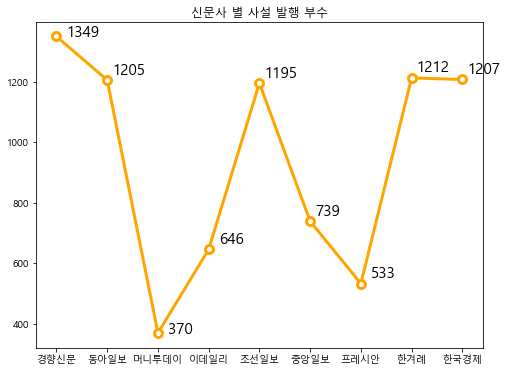

In [175]:
p = df.groupby('신문사')['기사'].count()

plt.figure(figsize=(8, 6))
plt.plot(p, marker="o", c="orange", lw=3, ms=8, mfc="w", mew=3)

plt.text(x=0.2, y=1349, s=1349, fontsize=15)
plt.text(x=1.1, y=1225, s=1205, fontsize=15)
plt.text(x=2.2, y=370, s=370, fontsize=15)
plt.text(x=3.2, y=666, s=646, fontsize=15)
plt.text(x=4.1, y=1215, s=1195, fontsize=15)
plt.text(x=5.1, y=759, s=739, fontsize=15)
plt.text(x=6.2, y=553, s=533, fontsize=15)
plt.text(x=7.1, y=1232, s=1212, fontsize=15)
plt.text(x=8.1, y=1227, s=1207, fontsize=15)


plt.title("신문사 별 사설 발행 부수")
plt.show()

In [7]:
nlp = stanza.Pipeline('ko')

2021-04-29 18:26:05 INFO: Loading these models for language: ko (Korean):
| Processor | Package |
-----------------------
| tokenize  | kaist   |
| pos       | kaist   |
| lemma     | kaist   |
| depparse  | kaist   |

2021-04-29 18:26:06 INFO: Use device: gpu
2021-04-29 18:26:06 INFO: Loading: tokenize
2021-04-29 18:26:08 INFO: Loading: pos
2021-04-29 18:26:08 INFO: Loading: lemma
2021-04-29 18:26:08 INFO: Loading: depparse
2021-04-29 18:26:09 INFO: Done loading processors!


In [72]:
def extract_nouns(text):
    doc = nlp(text)
    for sentence in doc.sentences:
        for word in sentence.words:
            lemma = word.lemma.split('+')
            xpos = word.xpos.split('+')
            for lem, pos in zip(lemma, xpos):
                if pos.startswith('n'):
                    yield lem

In [120]:
stop_words = ['정부', '국민', '대통령', '것', '만', '년', '수', '때', '일', '차', '1', '2', '3', '코로', '당코로', '오동희']
cv = CountVectorizer(max_features=2000, tokenizer=extract_nouns, stop_words=stop_words)

# <font color ='CC3D3D'>단어 빈도

- 전체신문사 단어구름

In [93]:
tdm1 = cv.fit_transform(df.loc[:,'기사'])

C:\Users\Administrator\anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:388: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['당코', '코'] not in stop_words.
  warnings.warn('Your stop_words may be inconsistent with '


In [94]:
word_count = pd.DataFrame({
    '단어': cv.get_feature_names(),
    '빈도': tdm1.sum(axis=0).flat
})

word_count.sort_values('빈도', ascending=False)
count_dic = word_count.set_index('단어')['빈도'].to_dict()

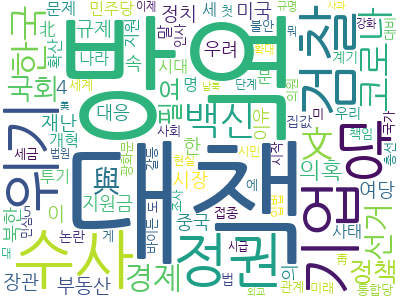

In [95]:
wc = WordCloud(font_path='C:/Windows/Fonts/NanumGothic.ttf',
               background_color='white',
               max_words=100,
               width=400, height=300)
cloud = wc.generate_from_frequencies(count_dic)
cloud.to_image()

In [96]:
word_count.sort_values('빈도', ascending=False).head(30)

,단어,빈도
729,방역,212
539,대책,208
1033,수사,180
478,당,177
386,기업,176
180,검찰,163
1255,위기,158
1511,정권,153
745,백신,151
1888,한국,150


- 보수 신문사 단어구름

In [97]:
right = df[df['성향']==1]
right.reset_index(drop=True, inplace=True)

In [98]:
tdm2 = cv.fit_transform(right.loc[:,'기사'])

In [99]:
word_count = pd.DataFrame({
    '단어': cv.get_feature_names(),
    '빈도': tdm2.sum(axis=0).flat
})

word_count.sort_values('빈도', ascending=False)
count_dic = word_count.set_index('단어')['빈도'].to_dict()

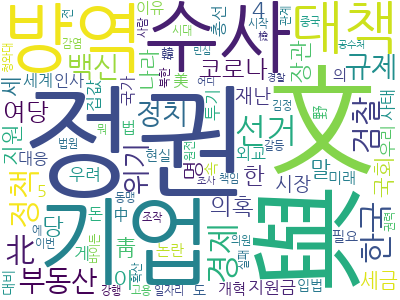

In [100]:
wc = WordCloud(font_path='C:/Windows/Fonts/NanumGothic.ttf',
               background_color='white',
               max_words=100,
               width=400, height=300)
cloud = wc.generate_from_frequencies(count_dic)
cloud.to_image()

In [101]:
word_count.sort_values('빈도', ascending=False).head(30)

,단어,빈도
86,文,139
1502,정권,139
103,與,136
393,기업,135
1057,수사,108
749,방역,103
545,대책,102
963,선거,98
230,경제,97
75,北,95


- 진보 신문사 단어구름

In [102]:
left = df[df['성향']==0]
left.reset_index(drop=True, inplace=True)

In [103]:
tdm3 = cv.fit_transform(left.loc[:,'기사'])

In [104]:
word_count = pd.DataFrame({
    '단어': cv.get_feature_names(),
    '빈도': tdm3.sum(axis=0).flat
})

word_count.sort_values('빈도', ascending=False)
count_dic = word_count.set_index('단어')['빈도'].to_dict()

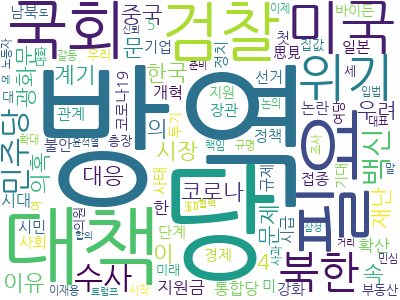

In [105]:
wc = WordCloud(font_path='C:/Windows/Fonts/NanumGothic.ttf',
               background_color='white',
               max_words=100,
               width=400, height=300)
cloud = wc.generate_from_frequencies(count_dic)
cloud.to_image()

In [106]:
word_count.sort_values('빈도', ascending=False).head(30)

,단어,빈도
748,방역,109
471,당,107
555,대책,106
1872,필요,90
173,검찰,78
324,국회,76
698,미국,76
1285,위기,74
844,북한,73
1053,수사,72


# <font color='CC3D3D'>감성 분석

In [107]:
x = tdm1
y = df['성향'].values

In [108]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=777)

In [109]:
model = tf.keras.models.Sequential()
model.add(tf.keras.layers.Dense(1, activation='sigmoid'))
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [110]:
model.fit(x_train.A, y_train, epochs=3)

Epoch 1/3
212/212 [==============================] - 1s 3ms/step - loss: 0.6906 - accuracy: 0.5370
Epoch 2/3
212/212 [==============================] - 1s 3ms/step - loss: 0.6675 - accuracy: 0.6770
Epoch 3/3
212/212 [==============================] - 1s 3ms/step - loss: 0.6486 - accuracy: 0.7262


In [111]:
model.evaluate(x_test.A, y_test)

53/53 [==============================] - 0s 2ms/step - loss: 0.6524 - accuracy: 0.6673


[0.6523794531822205, 0.6672576665878296]

In [119]:
w, b = model.weights
words = cv.get_feature_names()
word_sent = pd.DataFrame({'토큰' : words, '가중치' : w.numpy().flat})
display(word_sent.sort_values('가중치').head(20))
display(word_sent.sort_values('가중치').tail(20))

,토큰,가중치
291,괴물,-0.319028
1872,필요성,-0.220127
828,분노,-0.197984
1908,해결,-0.194457
71,巨與,-0.187081
213,계속,-0.187041
1044,수사권,-0.179908
1897,한심,-0.169354
1920,행위,-0.165257
1155,언행,-0.163001


,토큰,가중치
69,南,0.167239
87,與野,0.168951
1166,에,0.176758
1835,평가,0.181583
984,세경제,0.187221
1384,일정,0.193228
751,배제,0.193602
90,野,0.206158
1000,세월호,0.206819
62,’,0.216379


In [121]:
x_coo = x_train.tocoo()
index = np.column_stack([x_coo.row, x_coo.col])
x_train_sparse = tf.SparseTensor(index, x_coo.data, x_coo.shape)
x_train_sparse = tf.sparse.reorder(x_train_sparse)

In [122]:
model.fit(x_train_sparse, y_train, epochs=3)

Epoch 1/3
212/212 [==============================] - 1s 3ms/step - loss: 0.6276 - accuracy: 0.7488
Epoch 2/3
212/212 [==============================] - 1s 3ms/step - loss: 0.6119 - accuracy: 0.7617
Epoch 3/3
212/212 [==============================] - 1s 3ms/step - loss: 0.5977 - accuracy: 0.7726


In [123]:
model.fit(x_train.A, y_train, epochs=100, validation_split=0.1, callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss')])

Epoch 1/100
191/191 [==============================] - 1s 3ms/step - loss: 0.5852 - accuracy: 0.7831 - val_loss: 0.5819 - val_accuracy: 0.7607
Epoch 2/100
191/191 [==============================] - 1s 3ms/step - loss: 0.5739 - accuracy: 0.7881 - val_loss: 0.5770 - val_accuracy: 0.7563
Epoch 3/100
191/191 [==============================] - 1s 3ms/step - loss: 0.5636 - accuracy: 0.7887 - val_loss: 0.5727 - val_accuracy: 0.7578
Epoch 4/100
191/191 [==============================] - 1s 3ms/step - loss: 0.5539 - accuracy: 0.7946 - val_loss: 0.5689 - val_accuracy: 0.7518
Epoch 5/100
191/191 [==============================] - 1s 3ms/step - loss: 0.5449 - accuracy: 0.7976 - val_loss: 0.5655 - val_accuracy: 0.7459
Epoch 6/100
191/191 [==============================] - 1s 3ms/step - loss: 0.5366 - accuracy: 0.7992 - val_loss: 0.5625 - val_accuracy: 0.7415
Epoch 7/100
191/191 [==============================] - 1s 3ms/step - loss: 0.5288 - accuracy: 0.7992 - val_loss: 0.5600 - val_accuracy: 0.7430

In [124]:
from sklearn.neural_network import MLPClassifier
mlp_model = MLPClassifier(random_state=777)

pred = mlp_model.fit(x_train, y_train).predict(x_test)
accuracy_score(y_test, pred)

0.6879432624113475

In [125]:
from sklearn.svm import SVC
svm_model = SVC(random_state=777, kernel = 'rbf', probability=True)

pred = svm_model.fit(x_train, y_train).predict(x_test)
accuracy_score(y_test, pred)

0.6985815602836879

In [126]:
from sklearn.tree import DecisionTreeClassifier
dt_model = DecisionTreeClassifier(random_state=777)

pred = dt_model.fit(x_train, y_train).predict(x_test)
accuracy_score(y_test, pred)

0.6595744680851063

# <font color='CC3D3D'>주제 분석

### 文

In [151]:
svd = TruncatedSVD(n_components = 100, random_state=777)
svd.fit_transform(tdm1)
word_idx = words.index('與') ;word_idx

86

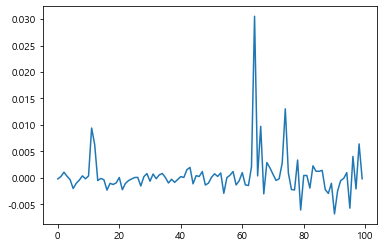

In [152]:
rotator = Rotator()
rot = rotator.fit_transform(svd.components_.T)
loading = rot.T
plt.plot(loading[:, word_idx])

In [153]:
topic_idx = loading[:, word_idx].argmax()
topic = pd.DataFrame({'word':words, 'loading':loading[topic_idx]})
topic.sort_values('loading').tail(20)

,word,loading
228,고집,0.041270
1041,수도권,0.041854
1943,협치,0.043357
400,김학,0.044707
153,개편,0.046625
694,민심,0.048206
1684,참담,0.048842
687,미얀마,0.049103
655,무능,0.049252
1550,조선,0.053977


In [154]:
doc_topics = svd.transform(tdm1)
doc_topics = doc_topics @ rotator.rotation_
newspaper_topic = pd.DataFrame({'신문사' : df.신문사, '與' : doc_topics[:, topic_idx]})
newspaper_topic.groupby('신문사').agg('mean')

,與
신문사,
경향신문,0.004219
동아일보,0.024034
머니투데이,0.004822
이데일리,0.004877
조선일보,0.045724
중앙일보,0.008831
프레시안,0.008374
한겨례,0.003412
한국경제,0.014984


### 광화문

In [155]:
svd = TruncatedSVD(n_components = 100, random_state=777)
svd.fit_transform(tdm1)
word_idx = words.index('광화문') ;word_idx

289

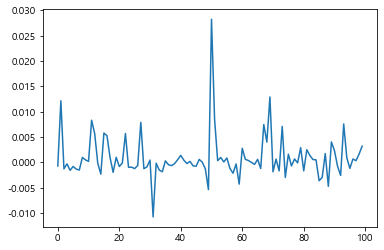

In [156]:
rotator = Rotator()
rot = rotator.fit_transform(svd.components_.T)
loading = rot.T
plt.plot(loading[:, word_idx])

In [157]:
topic_idx = loading[:, word_idx].argmax()
topic = pd.DataFrame({'word':words, 'loading':loading[topic_idx]})
topic.sort_values('loading').tail(20)

,word,loading
90,野,0.028306
1327,이건희,0.028546
1796,통합당,0.029165
1459,적폐,0.030077
1571,주,0.030533
1545,조건,0.032283
549,대표,0.032454
1782,탑,0.032917
1261,위기,0.033124
379,기생충,0.033225


In [159]:
doc_topics = svd.transform(tdm1)
doc_topics = doc_topics @ rotator.rotation_
newspaper_topic = pd.DataFrame({'신문사' : df.신문사, '광화문' : doc_topics[:, topic_idx]})
newspaper_topic.groupby('신문사').agg('mean')

,광화문
신문사,
경향신문,0.018268
동아일보,0.007764
머니투데이,0.002195
이데일리,0.018273
조선일보,0.009904
중앙일보,0.004760
프레시안,0.032524
한겨례,0.009113
한국경제,0.007895


### 정권

In [167]:
svd = TruncatedSVD(n_components = 100, random_state=777)
svd.fit_transform(tdm1)
word_idx = words.index('정권') ;word_idx

1506

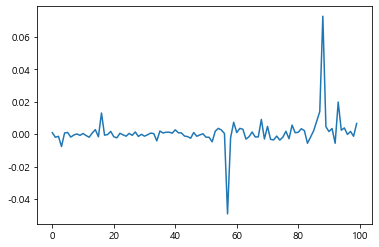

In [168]:
rotator = Rotator()
rot = rotator.fit_transform(svd.components_.T)
loading = rot.T
plt.plot(loading[:, word_idx])

In [169]:
topic_idx = loading[:, word_idx].argmax()
topic = pd.DataFrame({'word':words, 'loading':loading[topic_idx]})
topic.sort_values('loading').tail(20)

,word,loading
1331,이대로,0.062179
1339,이상직,0.062273
319,국정원,0.064701
1105,실장,0.066514
1594,중국,0.070273
202,경제,0.071253
785,보완책,0.072286
94,韓美,0.072634
1506,정권,0.072634
140,개각,0.073886


In [163]:
doc_topics = svd.transform(tdm1)
doc_topics = doc_topics @ rotator.rotation_
newspaper_topic = pd.DataFrame({'신문사' : df.신문사, '정권' : doc_topics[:, topic_idx]})
newspaper_topic.groupby('신문사').agg('mean')

,정권
신문사,
경향신문,0.015024
동아일보,0.000333
머니투데이,0.000906
이데일리,0.014681
조선일보,0.002724
중앙일보,0.008871
프레시안,0.005872
한겨례,0.006144
한국경제,0.003331
